In [1]:
# Read json file
import json
import numpy as np
import requests
import os
import pandas as pd
from sklearn import preprocessing
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

# Dataframe

In [2]:
playlists_df = pd.read_csv('playlists.csv')

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

print(headers)

['index', 'title', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


In [3]:
mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [4]:
playlists = json.load(open('playlists.json', 'r'))
tracks = json.load(open('track_features.json', 'r'))

# Clustering

### K-means

In [218]:
# K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def get_cluster_tracks(playlists_df, cluster_preds, num_clusters):
    global playlists, tracks
    
    playlists_clustered = playlists_df.get(['index', 'title']).copy()
    playlists_clustered['cluster'] = cluster_preds

    cluster_tracks = [{} for _ in range(num_clusters)]
    for cluster in range(num_clusters):
        for i in playlists_clustered[playlists_clustered['cluster'] == cluster]['index']:
            for track in playlists[i][1]:
                if track['track_uri'] not in cluster_tracks[cluster]:
                    cluster_tracks[cluster][track['track_uri']] = track
        cluster_tracks[cluster] = np.array(list(cluster_tracks[cluster].values()))

    return cluster_tracks

def track_disc_score(playlists_df, cluster_preds, num_clusters):
    global tracks
    
    cluster_tracks = get_cluster_tracks(playlists_df, cluster_preds, num_clusters)

    lengths = np.array([len(tracks) for tracks in cluster_tracks])
    return  np.sum(lengths) / len(tracks), np.max(lengths)/np.mean(lengths)

In [219]:
for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    print("n_clusters = {}, track_disc = {}, davies_bouldin = {}".format(
        i, track_disc_score(playlists_df, labels, i),
        davies_bouldin_score(playlists_df[headers[2:]], labels)))

n_clusters = 2, track_disc = (1.00631655630708, 1.2715961826512505), davies_bouldin = 1.5499797781262485
n_clusters = 3, track_disc = (1.0358826595278425, 1.6659129047658527), davies_bouldin = 1.5380131493438556
n_clusters = 4, track_disc = (1.1348686938084127, 1.472871170350732), davies_bouldin = 1.7068494614845537
n_clusters = 5, track_disc = (1.2019195460845051, 1.3339649000046814), davies_bouldin = 1.7157063598849223
n_clusters = 6, track_disc = (1.2527747835254261, 1.3758492064617698), davies_bouldin = 1.7661064928903503
n_clusters = 7, track_disc = (1.3087235403513344, 1.294509373550409), davies_bouldin = 1.7459275061880697
n_clusters = 8, track_disc = (1.318226507622511, 1.4816958107938105), davies_bouldin = 1.6580746811491074
n_clusters = 9, track_disc = (1.3675773800357731, 1.4337355919871635), davies_bouldin = 1.7372477600456848
n_clusters = 10, track_disc = (1.3786054417739662, 1.560147186128588), davies_bouldin = 1.7136125307738
n_clusters = 11, track_disc = (1.388099524999

In [220]:
NUM_CLUSTERS = 15
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto').fit(playlists_df[headers[2:]])

In [221]:
# Group playlists by cluster
playlists_df['cluster'] = kmeans.labels_
playlists_clustered = playlists_df.get(['index', 'title', 'cluster'])

In [222]:
# Count most common titles
def count_words(titles):
    words = []
    for title in titles:
        title = str(title).strip().lower()
        words += title.split(" ")
    return Counter(words)


for i in range(NUM_CLUSTERS):
    print(count_words(
        playlists_clustered[playlists_clustered['cluster'] == i]['title'].values.tolist()).most_common(10))

[('chill', 181), ('summer', 80), ('good', 63), ('jams', 57), ('music', 56), ('2017', 54), ('r&b', 54), ('vibes', 52), ('2016', 51), ('new', 47)]
[('christmas', 198), ('disney', 98), ('chill', 64), ('songs', 41), ('music', 40), ('the', 40), ('oldies', 36), ('feels', 28), ('sleep', 27), ('musicals', 24)]
[('chill', 146), ('songs', 85), ('love', 70), ('the', 61), ('music', 59), ('worship', 54), ('feels', 53), ('good', 47), ('sad', 43), ('new', 42)]
[('jazz', 33), ('chill', 20), ('music', 19), ('sleep', 12), ('instrumental', 11), ('la', 10), ('study', 9), ('piano', 8), ('the', 7), ('christmas', 7)]
[('chill', 32), ('house', 20), ('music', 12), ('playlist', 12), ('edm', 12), ('dubstep', 11), ('electro', 11), ('good', 10), ('summer', 10), ('2016', 10)]
[('party', 115), ('summer', 79), ('throwback', 78), ('dance', 75), ('old', 73), ('music', 72), ('workout', 60), ('jams', 55), ('songs', 51), ('playlist', 51)]
[('rap', 285), ('lit', 112), ('party', 98), ('hop', 93), ('hip', 89), ('workout', 79

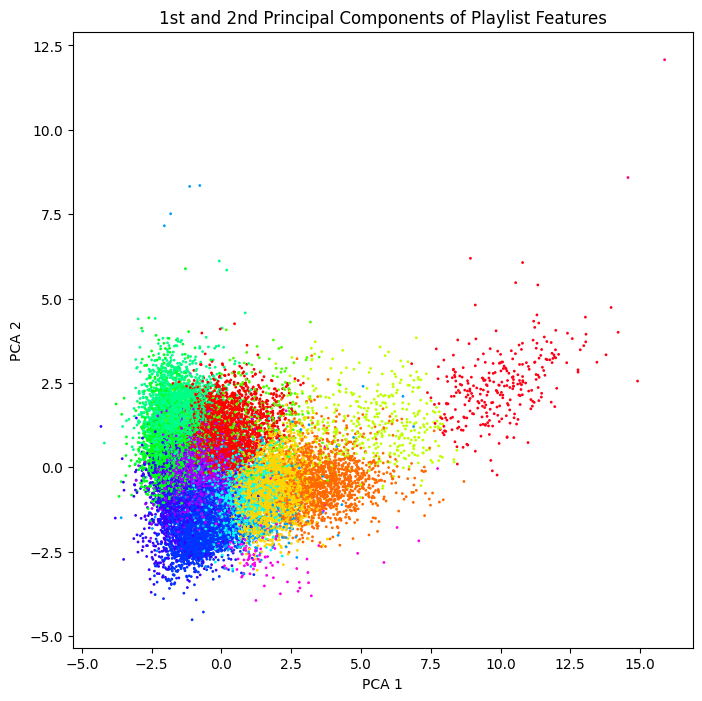

In [223]:
pca = PCA()
pca.fit(playlists_df[headers[2:]])
x = pca.transform(playlists_df[headers[2:]])[:, 0]
y = pca.transform(playlists_df[headers[2:]])[:, 1]

# Plot clusters
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=kmeans.labels_, s=1, cmap='hsv')
plt.title("1st and 2nd Principal Components of Playlist Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

### DBSCAN

In [ ]:
# DBSCAN
from sklearn.cluster import DBSCAN


for e in range(14, 20):
    e /= 10
    for min_samples in range(2, 10):
        db = DBSCAN(eps=e, min_samples=min_samples).fit(playlists_df[headers[2:]])
        labels = db.labels_ + 1 # now 0 is noise

        clusters = len(set(labels))
        noisy = len([l for l in labels if l == 0])

        print("eps = {}, min_samples = {}, clusters = {}, noisy = {}".format(
            e, min_samples, clusters, noisy), end="")

        if clusters > 1 and noisy < len(playlists_df) / clusters:
            print(", track_disc = {}, davies_bouldin = {}".format(
                track_disc_score(playlists_df, labels, len(set(labels))),
                davies_bouldin_score(playlists_df[headers[2:]], labels)))
        else:
            print()

In [40]:
eps = 1.6
min_samples = 9

db = DBSCAN(eps=eps, min_samples=min_samples).fit(playlists_df[headers[2:]])
labels = db.labels_ + 1 # now 0 is noise

In [41]:
playlists_clustered = playlists_df.get(['index', 'title']).copy()
playlists_clustered['cluster'] = labels

clusters = len(set(labels))
cluster_tracks = [set() for _ in range(clusters)]
for cluster in range(clusters):
    for i in playlists_clustered[playlists_clustered['cluster'] == cluster]['index']:
        for track in playlists[i][1]:
            cluster_tracks[cluster].add(track['track_uri'])

lengths = np.array([len(tracks) for tracks in cluster_tracks])
lengths

array([ 86547, 241716,    679,    525])

In [42]:
for i in range(clusters):
    print(count_words(
        playlists_clustered[playlists_clustered['cluster'] == i]['title'].values.tolist()).most_common(10))

[('music', 96), ('chill', 84), ('songs', 64), ('classical', 59), ('the', 55), ('christmas', 51), ('jazz', 48), ('new', 44), ('sleep', 42), ('good', 42)]
[('country', 864), ('chill', 584), ('music', 508), ('summer', 474), ('songs', 408), ('rock', 395), ('good', 369), ('party', 364), ('playlist', 343), ('jams', 336)]
[('harry', 2), ('potter', 2), ('soundtracks', 2), ('soundtrack', 1), ('speechless', 1), ('movie', 1), ('music', 1), ('study', 1), ('calm', 1)]
[('disney', 5), ('various', 2), ('artists', 2), ('–', 2), ('frozen', 2), ('oldie', 1), ('music', 1), ('<3', 1), ('movies', 1)]


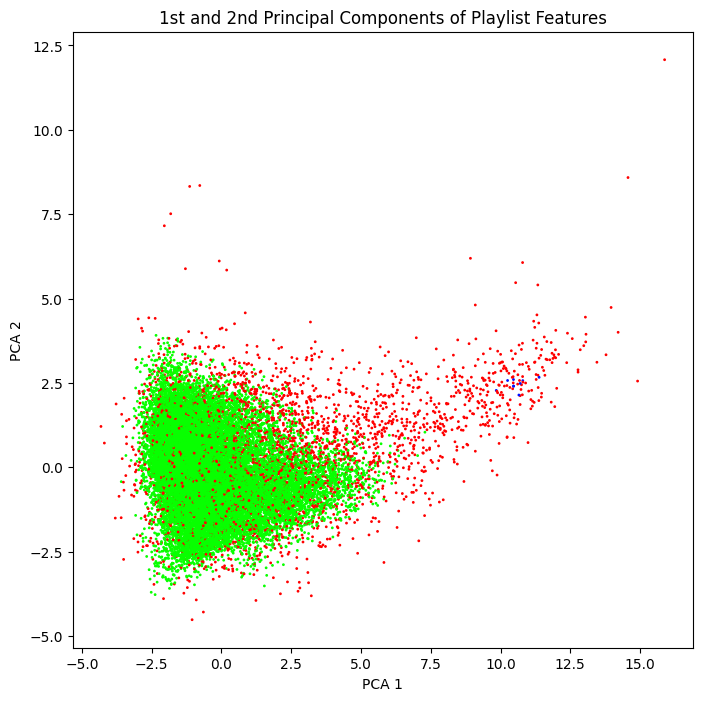

In [43]:
pca = PCA()
pca.fit(playlists_df[headers[2:]])
x = pca.transform(playlists_df[headers[2:]])[:, 0]
y = pca.transform(playlists_df[headers[2:]])[:, 1]

# Plot clusters
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=labels, s=1, cmap='hsv')
plt.title("1st and 2nd Principal Components of Playlist Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Test data

In [224]:
test_playlists_df['cluster'] = kmeans.predict(test_playlists_df[headers[2:]])
test_playlists_clustered = test_playlists_df.get(['index', 'title', 'cluster'])

for i in range(NUM_CLUSTERS):
    print(count_words(
        test_playlists_clustered[test_playlists_clustered['cluster'] == i]['title'].values.tolist()).most_common(10))

[('chill', 51), ('summer', 21), ('2017', 18), ('vibes', 17), ('good', 16), ('new', 15), ('2016', 14), ('slow', 13), ('feels', 12), ('playlist', 10)]
[('christmas', 55), ('chill', 21), ('disney', 20), ('songs', 12), ('music', 11), ('sleep', 7), ('wedding', 7), ('sad', 7), ('oldies', 7), ('2017', 6)]
[('chill', 37), ('songs', 22), ('love', 16), ('sad', 12), ('feels', 11), ('the', 11), ('music', 11), ('country', 11), ('2016', 11), ('wedding', 10)]
[('jazz', 7), ('sleep', 7), ('yoga', 5), ('study', 4), ('words', 3), ('instrumental', 2), ('movie', 2), ('classical', 2), ('la', 2), ('celtic', 2)]
[('chill', 6), ('house', 5), ('playlist', 4), ('edm', 4), ('2016', 4), ('2017', 3), ('electronic', 3), ('summer', 3), ('2015', 3), ('april', 3)]
[('party', 26), ('dance', 22), ('songs', 22), ('music', 18), ('summer', 18), ('workout', 16), ('throwbacks', 16), ('old', 16), ('throwback', 13), ('school', 12)]
[('rap', 75), ('lit', 31), ('party', 29), ('workout', 24), ('playlist', 18), ('music', 16), ('su

# Get recommendations

In [225]:
cluster_tracks = get_cluster_tracks(playlists_df, playlists_df['cluster'], NUM_CLUSTERS)

In [257]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms', 'time_signature']

def get_playlist_features(playlist_tracks, mean=mean, std=std):
    features = [np.mean([track[col] for track in playlist_tracks]) for col in cols]
    return (features - mean) / std

def get_track_info(tracks):
    return np.array([[s['artist_name'], s['track_name']] for s in tracks])

def get_track_features(tracks):
    features = np.array([[s[col] for col in cols] for s in tracks])
    return (features - np.array(mean)) / np.array(std)

In [228]:
PART_PERCENT = 0.8

count = 0
for test_i in range(len(test_playlists_df)):
    i = test_playlists_df.iloc[test_i]['index']

    playlist_part_features = np.array(get_playlist_features(
        playlists[i][1][:int(len(playlists[i][1]) * PART_PERCENT)]))

    playlist_features = np.array(test_playlists_df.iloc[test_i][headers[2:]].values)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        real_cluster = kmeans.predict([playlist_features])[0]
        part_cluster = kmeans.predict([playlist_part_features])[0]

    count += 1 if real_cluster == part_cluster else 0

print(count / len(test_playlists_df))

0.8490597716588314


In [259]:
test_i = np.random.randint(len(test_playlists_df))
i = test_playlists_df.iloc[test_i]['index']

playlist_name = playlists[i][0]

playlist_part_features = np.array(get_playlist_features(
    playlists[i][1][:int(len(playlists[i][1]) * PART_PERCENT)]))

playlist_features = np.array(test_playlists_df.iloc[test_i][headers[2:]].values, dtype='float32')

num_tracks = len(playlists[i][1])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    real_cluster = kmeans.predict([playlist_features])[0]
    part_cluster = kmeans.predict([playlist_part_features])[0]

print("Playlist name: {}".format(playlist_name))
print("Number of tracks: {}".format(num_tracks))
print("Real cluster: {}".format(real_cluster))
print("Part cluster: {}".format(part_cluster))
print(get_track_info(playlists[i][1][:10]))

Playlist name: aux
Number of tracks: 88
Real cluster: 11
Part cluster: 6
[['21 Savage' 'Dip Dip']
 ['Chief Keef' 'Love Sosa']
 ['DRAM' 'Broccoli (feat. Lil Yachty)']
 ['Snakehips' 'All My Friends']
 ['Kanye West' 'Father Stretch My Hands Pt. 1']
 ['21 Savage' 'X (feat. Future)']
 ['Lil Yachty' 'One Night']
 ['KYLE' 'King Wavy (feat. G-Eazy)']
 ['Damion' 'In The Nights']
 ['Lil Uzi Vert' 'You Was Right']]


In [260]:
def k_nn(k, playlist_features, track_features):
    distances = np.linalg.norm(track_features - playlist_features, axis=1)
    return np.argsort(distances)[:k]

tracks_in_cluster = cluster_tracks[part_cluster]
tracks_info = get_track_info(tracks_in_cluster)
[tracks_info[i]
    for i in k_nn(10, playlist_part_features, get_track_features(tracks_in_cluster))]

[array(['Future', 'Rider'], dtype='<U218'),
 array(['Galantis', 'Tell Me You Love Me'], dtype='<U218'),
 array(['David Rush', 'Shooting Star - Party Rock Mix'], dtype='<U218'),
 array(['Chuuwee', 'Frieza'], dtype='<U218'),
 array(['Rob Curly', 'Eleven 11: / 11'], dtype='<U218'),
 array(['SZA', 'Broken Clocks'], dtype='<U218'),
 array(['Eric Bellinger', 'Sometimes'], dtype='<U218'),
 array(['Bankroll Fresh', 'Hot Boy'], dtype='<U218'),
 array(['Kari Parker', 'Bette Davis Eyes'], dtype='<U218'),
 array(['Derek Minor', 'Party People (feat. Social Club)'], dtype='<U218')]